# Will discover these topics
1. Encoder-Decoder
2. BiDirectional Layer
3. Beam Search
4. Attention
5. Transformers (Multi-Head Attention)

# 1. Encoder-Decoder
Building a Neural Machine Translation system using Encoder-Decoder (Seq-to-Seq Net)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

def cls():
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
##########################################
# Lets download some dataset first       #
# That will translate english to spanish #
##########################################
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)

In [38]:
with open((Path(path).with_name("spa-eng") / "spa.txt"), "r", encoding='utf-8') as f:
    text = f.read()

In [39]:
print(text[:100])

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fueg


In [40]:
text.splitlines()[:10]

['Go.\tVe.',
 'Go.\tVete.',
 'Go.\tVaya.',
 'Go.\tVáyase.',
 'Hi.\tHola.',
 'Run!\t¡Corre!',
 'Run.\tCorred.',
 'Who?\t¿Quién?',
 'Fire!\t¡Fuego!',
 'Fire!\t¡Incendio!']

In [41]:
text = text.replace("¡", "").replace("¿", "") # Replacing chracters
pairs = [line.split("\t") for line in text.splitlines()] # spliting the lines from \n first then by \t
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # separates the pairs into 2 lists

In [43]:
for i in range(5):
    print(sentences_en[i], "=>", sentences_es[i])

You don't have to believe me. => No tienen que creerme.
I hardly even know you. => Apenas te conozco.
How many boys are in this class? => Cuántos niños hay en esta clase?
Why didn't you believe me? => Por qué no me creíste?
We met there yesterday. => Nos conocimos ahí ayer.


In [44]:
# There would be around 25_512 unique word in dataset
len(set(" ".join(sentences_en).split()))

25512

In [45]:
# After doing preprocessing like, remove puntuations, lowering, etc.
# total unique values would be around 13634

text_vec_layer_en = tf.keras.layers.TextVectorization()
text_vec_layer_en.adapt(sentences_en)
size = len(text_vec_layer_en.get_vocabulary())
size

13634

In [46]:
st = "Hello world my name is khan."
print(f"There are total {size} element is vocabulary.")
print("Word to Vector : ", text_vec_layer_en(st).numpy())
print("Vector to Word : ", np.asarray(text_vec_layer_en.get_vocabulary())[[text_vec_layer_en(st).numpy()]])

There are total 13634 element is vocabulary.
Word to Vector :  [1800  319   19  233    8 6607]
Vector to Word :  [['hello' 'world' 'my' 'name' 'is' 'khan']]


In [47]:
# Lets build the vocabulary of words with 1000 and max length 50
# any sentence have more than 50 words would be ignore


vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
# Let add <SOS> and <EOS> to target sequence. 
# <SOS> fed as input while <EOS> model predict as last word
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [48]:
text_vec_layer_en.get_vocabulary()[:5]

['', '[UNK]', 'the', 'i', 'to']

In [49]:
text_vec_layer_es.get_vocabulary()[:5]

['', '[UNK]', 'startofseq', 'endofseq', 'de']

In [50]:
# input for encoder
X_train_enc = tf.constant(sentences_en[:100_000])
X_valid_enc = tf.constant(sentences_en[100_000:])

# input for decoder
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])

# output for decoder
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [82]:
X_train_dec[2]

<tf.Tensor: shape=(), dtype=string, numpy=b'startofseq Cu\xc3\xa1ntos ni\xc3\xb1os hay en esta clase?'>

In [91]:
print("X_train Encoder : ", X_train_enc[0].numpy())
print("X_train Decoder : ", X_train_dec[0].numpy())
print("Y_train Decoder : ", Y_train[0].numpy())
print(f"{Y_train.shape}")

X_train Encoder :  b"You don't have to believe me."
X_train Decoder :  b'startofseq No tienen que creerme.'
Y_train Decoder :  [  7 268   5   1   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
(100000, 50)


In [92]:
cls()

embed_size = 12 # Change embedding dimension 12 to 128 for better result

# Layer 1 & 2 of Encoder
encoder_inputs     = tf.keras.layers.Input(shape=[], dtype=tf.string)
encoder_input_ids  = text_vec_layer_en(encoder_inputs)
encoder_embeddings = tf.keras.layers.Embedding(vocab_size, embed_size,mask_zero=True)(encoder_input_ids)
encoder_outputs, *encoder_state = tf.keras.layers.LSTM(2, return_state=True)(encoder_embeddings) # chng 2 to 512, rturn all the LSTM states with output

# Layer 1 & 2 of Decoder
decoder_inputs     = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_input_ids  = text_vec_layer_es(decoder_inputs)
decoder_embeddings = tf.keras.layers.Embedding(vocab_size, embed_size,mask_zero=True)(decoder_input_ids)
decoder_outputs    = tf.keras.layers.LSTM(2, return_sequences=True)(decoder_embeddings, initial_state=encoder_state) # Change this to 512

# Layer 3 of Decoder
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(decoder_outputs)

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_5 (TextVect  (None, 50)          0           ['input_1[0][0]']                
 orization)                                                                                       
                                                                                                  
 text_vectorization_6 (TextVect  (None, 50)          0           ['input_2[0][0]']            

In [93]:
model.fit((X_train_enc, X_train_dec), Y_train, epochs=1, validation_data=((X_valid_enc, X_valid_dec), Y_valid))

3125/3125 [==============================] - 219s 68ms/step - loss: 0.7032 - accuracy: 0.1581 - val_loss: 0.6490 - val_accuracy: 0.1729


In [94]:
translation = ""
for i in range(10):
    str = "I love my life"
    X_enc = np.array([str])
    X_dec = np.array(['startofseq ' + translation])
    y_proba = model.predict((X_enc,X_dec))
    predicted_word = text_vec_layer_es.get_vocabulary()[(np.argmax(y_proba[0,i]))]
    translation += " " + predicted_word
print(translation)

1/1 [==============================] - 0s 26ms/step
 [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]


In [95]:
# Lets create a function that will translate our language
def translate(sentence_en, max_length=50):
    translation = ""
    for word_idx in range(max_length): # 50
        X = np.array([sentence_en])  # encoder input 
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
        print(translation)
    return translation.strip()

In [96]:
translate("I love my life", 5)

1/1 [==============================] - 0s 24ms/step
 [UNK]
1/1 [==============================] - 0s 25ms/step
 [UNK] [UNK]
1/1 [==============================] - 0s 25ms/step
 [UNK] [UNK] [UNK]
1/1 [==============================] - 0s 24ms/step
 [UNK] [UNK] [UNK] [UNK]
1/1 [==============================] - 0s 26ms/step
 [UNK] [UNK] [UNK] [UNK] [UNK]


'[UNK] [UNK] [UNK] [UNK] [UNK]'

In [97]:
# We need to increase models complexity as it didn't learn anything yet.

# 2. BiDirectional RNNs

In [124]:
cls()

embed_size = 12 # Change embedding dimension 12 to 128 for better result

# Layer 1 & 2 of Encoder
encoder_inputs     = tf.keras.layers.Input(shape=[], dtype=tf.string)
encoder_input_ids  = text_vec_layer_en(encoder_inputs)
encoder_embeddings = tf.keras.layers.Embedding(vocab_size, embed_size,mask_zero=True)(encoder_input_ids)
encoder_outputs, *encoder_state  = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2, return_state=True))(encoder_embeddings)
encoder_state      = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                      tf.concat(encoder_state[1::2], axis=-1)]

# Layer 1 & 2 of Decoder
decoder_inputs     = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_input_ids  = text_vec_layer_es(decoder_inputs)
decoder_embeddings = tf.keras.layers.Embedding(vocab_size, embed_size,mask_zero=True)(decoder_input_ids)
decoder_outputs    = tf.keras.layers.LSTM(4, return_sequences=True)(decoder_embeddings, initial_state=encoder_state) # Decoder neuron 2X of encoder
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(decoder_outputs)
model  = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_5 (TextVect  (None, 50)          0           ['input_1[0][0]']                
 orization)                                                                                       
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 12)       12000       ['text_vectorization_5[21][0]

In [125]:
model.fit((X_train_enc, X_train_dec), Y_train, epochs=1, validation_data=((X_valid_enc, X_valid_dec), Y_valid))

3125/3125 [==============================] - 197s 61ms/step - loss: 0.6773 - accuracy: 0.1834 - val_loss: 0.6294 - val_accuracy: 0.2516


In [126]:
translate("I love my life", 5)

1/1 [==============================] - 3s 3s/step
 [UNK]
1/1 [==============================] - 0s 25ms/step
 [UNK] [UNK]
1/1 [==============================] - 0s 31ms/step
 [UNK] [UNK] [UNK]
1/1 [==============================] - 0s 23ms/step


'[UNK] [UNK] [UNK]'

# 3. Beam Search

This is a very basic implementation of beam search. I tried to make it readable and understandable, but it's definitely not optimized for speed! The function first uses the model to find the top k words to start the translations (where k is the beam width). For each of the top k translations, it evaluates the conditional probabilities of all possible words it could add to that translation. These extended translations and their probabilities are added to the list of candidates. Once we've gone through all top k translations and all words that could complete them, we keep only the top k candidates with the highest probability, and we iterate over and over until they all finish with an EOS token. The top translation is then returned (after removing its EOS token).

- *Note: If p(S) is the probability of sentence S, and p(W|S) is the conditional probability of the word W given that the translation starts with S, then the probability of the sentence S' = concat(S, W) is p(S') = p(S) p(W|S). As we add more words, the probability gets smaller and smaller. To avoid the risk of it getting too small, which could cause floating point precision errors, the function keeps track of log probabilities instead of probabilities: recall that log(a\b) = log(a) + log(b), therefore log(p(S')) = log(p(S)) + log(p(W|S)).*

In [154]:
# basic implementation of beam search

def beam_search(sentence_en, beam_width, verbose=False, max_length=50):
    X = np.array([sentence_en])       # encoder input
    X_dec = np.array(["startofseq"])  # decoder input
    y_proba = model.predict((X, X_dec))[0, 0]  # first token's probas
    top_k = tf.math.top_k(y_proba, k=beam_width)
    # list of best (log_proba, translation)
    top_translations = [(np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id]) for word_proba, word_id in zip(top_k.values, top_k.indices)]
    
    if verbose:
        print("Top first words:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # translation is finished, so don't try to extend it
            X = np.array([sentence_en])  # encoder input
            X_dec = np.array(["startofseq " + translation])  # decoder input
            y_proba = model.predict((X, X_dec))[0, idx]  # last token's proba
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        if verbose:
            print("Top translations so far:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()


In [129]:
# extra code – shows how the model making an error
sentence_en = "I love cats and dogs"
translate(sentence_en)

1/1 [==============================] - 0s 21ms/step
 [UNK]
1/1 [==============================] - 0s 25ms/step
 [UNK] [UNK]
1/1 [==============================] - 0s 23ms/step
 [UNK] [UNK] [UNK]
1/1 [==============================] - 0s 22ms/step
 [UNK] [UNK] [UNK] [UNK]
1/1 [==============================] - 0s 22ms/step


'[UNK] [UNK] [UNK] [UNK]'

In [130]:
# shows how beam search can help
beam_search(sentence_en, beam_width=3, verbose=True)

1/1 [==============================] - 0s 19ms/step
Top first words: [(-2.2651594, '[UNK]'), (-3.3839438, 'no'), (-3.5073543, 'que')]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(-4.3026166, '[UNK] [UNK]'), (-5.4967394, '[UNK] endofseq'), (-5.6409054, '[UNK] no')]
1/1 [==============================] - 0s 19ms/step
Top translations so far: [(-5.4967394, '[UNK] endofseq'), (-6.02695, '[UNK] [UNK] [UNK]'), (-6.698579, '[UNK] [UNK] endofseq')]
1/1 [==============================] - 0s 18ms/step
Top translations so far: [(-5.4967394, '[UNK] endofseq'), (-6.698579, '[UNK] [UNK] endofseq'), (-7.5446873, '[UNK] [UNK] [UNK] [UNK]')]
1/1 [==============================] - 0s 23ms/step
Top translations so far: [(-5.4967394, '[UNK] endofseq'), (-6.698579, '[UNK] [UNK] endofseq'), (-8.7092085, '[UNK] [UNK] [UNK] [UNK] endofseq')]


'[UNK]'

*The correct translation is in the top 3 sentences found by beam search, but it's not the first. Since we're using a small vocabulary, the [UNK] token is quite frequent, so you may want to penalize it (e.g., divide its probability by 2 in the beam search function): this will discourage beam search from using it too much.*

# 4. Attention Mechanisms

We need to feed all the encoder's outputs to the `Attention` layer, so we must add `return_sequences=True` to the encoder:

In [149]:
cls()

encoder_outputs, *encoder_state  = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2, return_sequences=True, return_state=True))(encoder_embeddings)
encoder_states      = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                      tf.concat(encoder_state[1::2], axis=-1)]  # long-term  (1 & 3)

decoder_outputs   = tf.keras.layers.LSTM(4, return_sequences=True)(decoder_embeddings, initial_state=encoder_states) # Decoder neuron 2X of encoder
attention_outputs = tf.keras.layers.Attention()([decoder_outputs, encoder_outputs]) # [Query, Value, Key] | If key not given then Value as key used 
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(attention_outputs)
model  = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_5 (TextVect  (None, 50)          0           ['input_1[0][0]']                
 orization)                                                                                       
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 12)       12000       ['text_vectorization_5[21][0]

In [147]:
model.fit((X_train_enc, X_train_dec), Y_train, epochs=1, validation_data=((X_valid_enc, X_valid_dec), Y_valid))

3125/3125 [==============================] - 343s 105ms/step - loss: 0.6844 - accuracy: 0.1636 - val_loss: 0.6490 - val_accuracy: 0.1729


In [152]:
translate("I like soccer and also going to the beach",5)

1/1 [==============================] - 0s 28ms/step
 empleo
1/1 [==============================] - 0s 28ms/step
 empleo empleo
1/1 [==============================] - 0s 31ms/step
 empleo empleo empleo
1/1 [==============================] - 0s 28ms/step
 empleo empleo empleo empleo
1/1 [==============================] - 0s 26ms/step
 empleo empleo empleo empleo empleo


'empleo empleo empleo empleo empleo'

In [155]:
beam_search("I like soccer and also going to the beach", beam_width=3, verbose=True, max_length=5)

1/1 [==============================] - 0s 34ms/step
Top first words: [(-6.889813, 'empleo'), (-6.890078, 'dentro'), (-6.8903437, 'comió')]
1/1 [==============================] - 0s 24ms/step
Top translations so far: [(-13.779625, 'empleo empleo'), (-13.779892, 'empleo dentro'), (-13.779892, 'dentro empleo')]
1/1 [==============================] - 0s 32ms/step
Top translations so far: [(-20.669436, 'empleo empleo empleo'), (-20.669704, 'empleo empleo dentro'), (-20.669704, 'empleo dentro empleo')]
1/1 [==============================] - 0s 24ms/step
Top translations so far: [(-27.559246, 'empleo empleo empleo empleo'), (-27.559517, 'empleo empleo empleo dentro'), (-27.559517, 'empleo empleo dentro empleo')]
1/1 [==============================] - 0s 26ms/step
Top translations so far: [(-34.449055, 'empleo empleo empleo empleo empleo'), (-34.449326, 'empleo empleo empleo empleo dentro'), (-34.44933, 'empleo empleo empleo dentro empleo')]


# 5. The Transformer (Attention is All you Need)

### A. The Positional Encoding
A positional embedding is a dense vector that encodes the position of a word within a sentense. Th i^th positional embedding is simply added to the word embedding of the i^th word in the sentence 

In [191]:
max_length = 50  # max length in the whole training set
embed_size = 12
cls()
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

Alternatively, we can use fixed, non-trainable positional encodings:

In [192]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [193]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

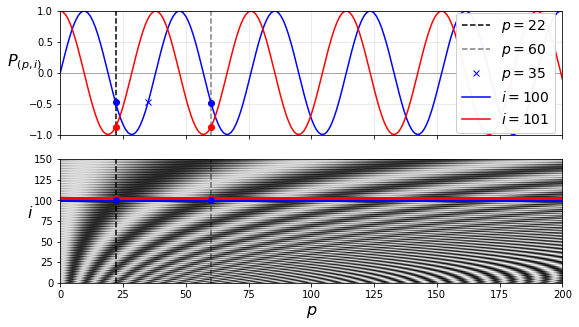

In [195]:
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()

### B. Multi-Head Attention

In [198]:
N = 1  # In paper this N is 6
num_heads = 8
dropout_rate = 0.1
n_units = 4  # for the first Dense layer in each Feed Forward block units=128
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in # First, feed the positional + Word embedding
for _ in range(N): # N=2
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.Add()([Z, skip])
    Z = tf.keras.layers.LayerNormalization()(Z)
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.Add()([Z, skip])
    Z = tf.keras.layers.LayerNormalization()(Z)

In [199]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part(  # creates a lower triangular matrix
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0)
encoder_outputs = Z  # let's save the encoder's final outputs
Z = decoder_in  # the decoder starts with its own inputs
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_6 (TextVect  (None, 50)          0           ['input_2[0][0]']                
 orization)                                                                                       
                                                                                                  
 text_vectorization_5 (TextVect  (None, 50)          0           ['input_1[0][0]']          

In [200]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
model.fit((X_train_enc, X_train_dec), Y_train, epochs=1, validation_data=((X_valid_enc, X_valid_dec), Y_valid))

3125/3125 [==============================] - 379s 120ms/step - loss: 0.5080 - accuracy: 0.3584 - val_loss: 0.3958 - val_accuracy: 0.4574


In [201]:
translate("I like soccer and also going to the beach", 10)

1/1 [==============================] - 1s 630ms/step
 me
1/1 [==============================] - 0s 23ms/step
 me gusta
1/1 [==============================] - 0s 24ms/step
 me gusta la
1/1 [==============================] - 0s 20ms/step
 me gusta la puerta
1/1 [==============================] - 0s 24ms/step
 me gusta la puerta y
1/1 [==============================] - 0s 22ms/step
 me gusta la puerta y [UNK]
1/1 [==============================] - 0s 26ms/step


'me gusta la puerta y [UNK]'